In [ ]:
using DiffEqFlux, DifferentialEquations, Plots, GalacticOptim, DelimitedFiles;

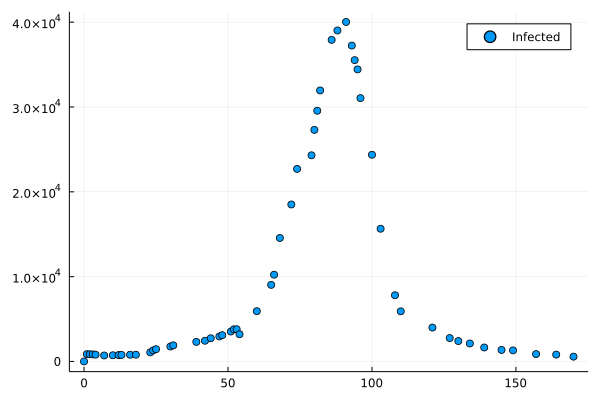

In [10]:
Infected = readdlm("covid.txt",',');
scatter(Infected[:,1],Infected[:,2],label="Infected")

In [ ]:
function EpMod(x, p, t)
    s, e, i, r = x
    γ, R₀, σ = p
    return [-γ*R₀*s*i;       # ds/dt = -γR₀si
             γ*R₀*s*i -  σ*e;# de/dt =  γR₀si -σe
             σ*e - γ*i;      # di/dt =         σe -γi
                   γ*i;      # dr/dt =             γi
            ]
end

In [ ]:
function F_simple(x, p, t; γ = 1/18, R₀ = 3.0, σ = 1/5.2)
    s, e, i, r = x

    return [-γ*R₀*s*i;       # ds/dt = -γR₀si
             γ*R₀*s*i -  σ*e;# de/dt =  γR₀si -σe
             σ*e - γ*i;      # di/dt =         σe -γi
                   γ*i;      # dr/dt =             γi
            ]
end

In [ ]:
i_0 = 1E-7                  # 33 = 1E-7 * 330 million population = initially infected
e_0 = 4.0 * i_0             # 132 = 1E-7 *330 million = initially exposed
s_0 = 1.0 - i_0 - e_0
r_0 = 0.0
x_0 = [s_0, e_0, i_0, r_0]  # initial condition
γ = 1/18
R₀ = 3.0
σ = 1/5.2 # parameters
p_0 = [γ,R₀,σ]

tspan = (0.0, 350.0)  # ≈ 350 days
prob = ODEProblem(EpMod, x_0, tspan, p_0)
#prob = ODEProblem(F_simple, x_0, tspan)

In [ ]:
sol = solve(prob, Tsit5())
sol2 = solve(prob,Tsit5(),saveat=0.1)
plot(sol, labels = ["s" "e" "i" "r"], title = "SEIR Dynamics", lw = 2, xlabel = "t")
t = 0:0.1:350
tshort = 1:100:3500
A = sol2[1,tshort] # length 101 vector
scatter!(0:10:350,A)

In [ ]:
p = [1/15,2.8,0.2]
params = Flux.params(p)

function predict_rd() # Our 1-layer "neural network"
  solve(prob,Tsit5(),p=p,saveat=0.1)[1,:] # override with new parameters
end

loss_rd() = sum(abs2,x-1 for x in predict_rd()) # loss function

In [ ]:
data = Iterators.repeated((), 100)
opt = ADAM(0.1)
cb = function () #callback function to observe training
  display(loss_rd())
  # plot current prediction against data
  cur_pred = predict_rd()
  pl = scatter(0:10:350,A,label="data")
  scatter!(pl,t,cur_pred[1,:],label="prediction")
  display(plot(pl))
end

# Display the ODE with the initial parameter values.
cb()

Flux.train!(loss_rd, params, data, opt, cb = cb)